In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
from typing import Optional

import pandas as pd
from IPython.display import Image
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsforecast.arima import ARIMASummary, ndiffs, nsdiffs
from statsforecast.models import ARIMA, AutoARIMA, AutoETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from utilsforecast.losses import mae, rmse, smape

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

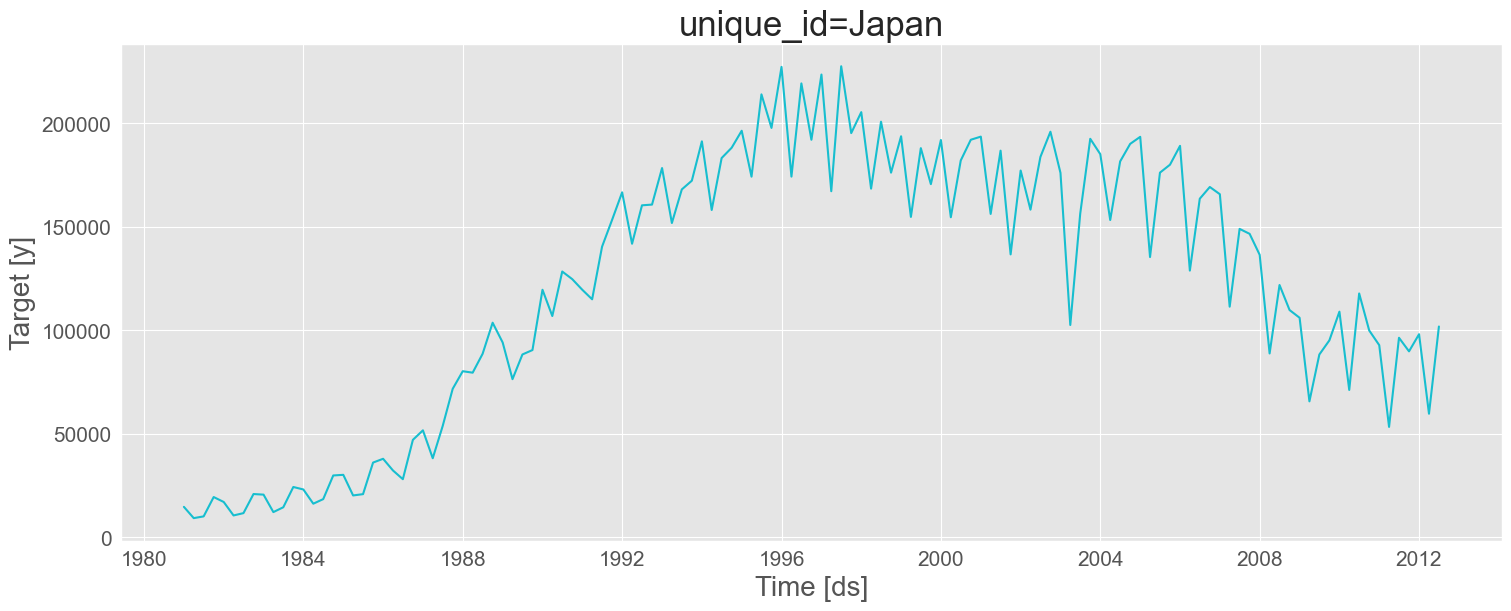

In [17]:
df = pd.read_csv("../DATA/aus_arrivals.csv")
df.Quarter = pd.to_datetime(df.Quarter)
df = df[df.Origin == "Japan"]
df = df.rename({"Quarter": "ds", "Origin": "unique_id", "Arrivals": "y"}, axis=1)
plot_series(df)

<Axes: ylabel='y'>

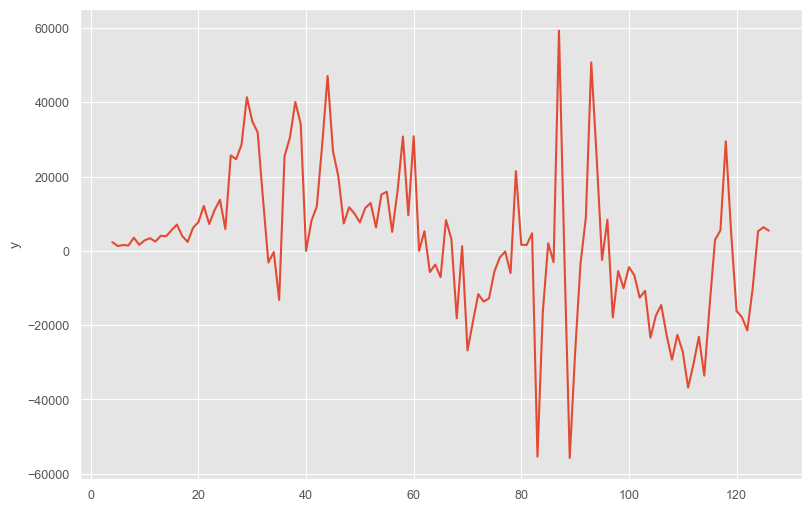

In [32]:
nsdiffs(df.y, period=4)
sdif_y = df.y.diff(4).dropna()
sns.lineplot(sdif_y)

C:\Users\basti\AppData\Local\Temp\ipykernel_25816\3011267101.py:4: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(y_stationary)[1]


0.1

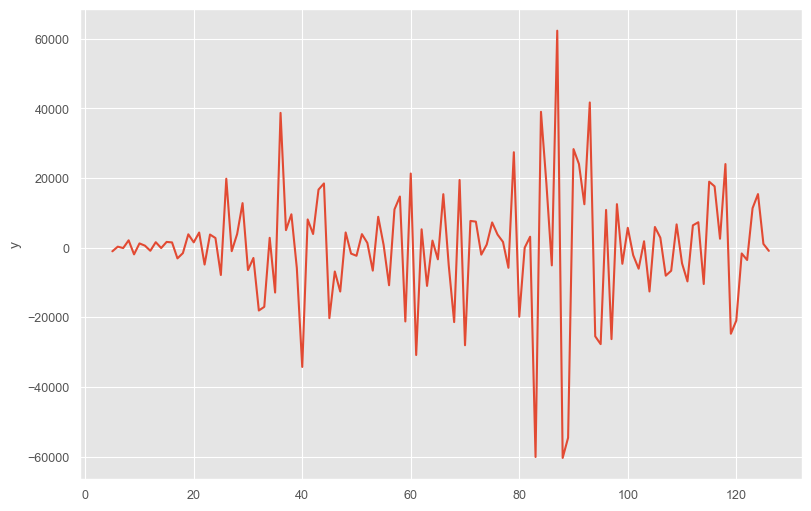

In [38]:
ndiffs(sdif_y.values)
y_stationary = sdif_y.diff().dropna()
sns.lineplot(y_stationary)
kpss(y_stationary)[1]

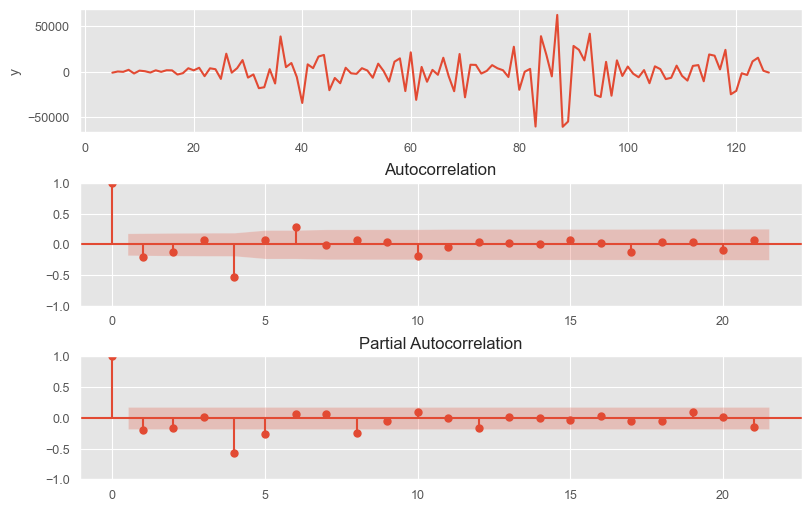

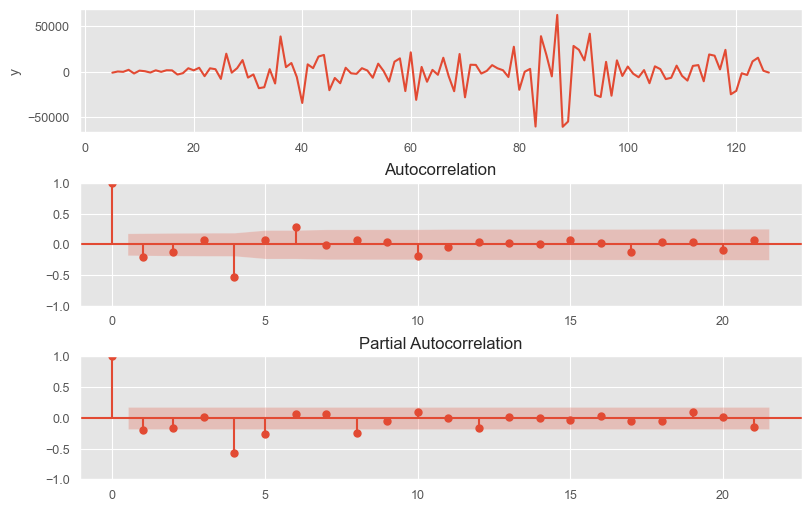

In [42]:
_, axes = plt.subplots(3, 1)

sns.lineplot(y_stationary, ax=axes[0])
plot_acf(y_stationary, ax=axes[1])
plot_pacf(y_stationary, ax=axes[2])

In [62]:
# Visual Suggesting : SARIMA (1,1,1)(1,1,1)

auto_model = AutoARIMA(season_length=4, stepwise=False, approximation=False).fit(df.y)
manual_model = ARIMA(order=(1, 1, 1), season_length=4, seasonal_order=(1, 1, 1)).fit(
    df.y
)

In [64]:
ARIMASummary(auto_model.model_)

ARIMA(0,1,1)(1,1,1)[4]                   

In [63]:
auto_model.model_["aicc"], manual_model.model_["aicc"]

(2666.459489374955, 2667.113591902009)